# SpectrogramMatrix Tutorial

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tatsuki-washimi/gwexpy/blob/main/docs/web/en/user_guide/tutorials/matrix_spectrogram.ipynb)

このノートブックでは `gwexpy` の `SpectrogramMatrix` クラスの基本的な使い方を紹介します。

`SpectrogramMatrix` は、複数の `gwpy.spectrogram.Spectrogram` オブジェクトを 3次元 (Batch, Time, Frequency) の行列として効率的に扱うためのクラスです。`numpy.ndarray` を継承しており、高速な数値計算や PyTorch/CuPy との連携が可能です。

In [1]:
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np

from gwexpy.timeseries import TimeSeriesMatrix

#
np.random.seed(42)

## 1. データの準備



<SeriesMatrix shape=(2, 2, 512) rows=('r0', 'r1') cols=('c0', 'c1')>

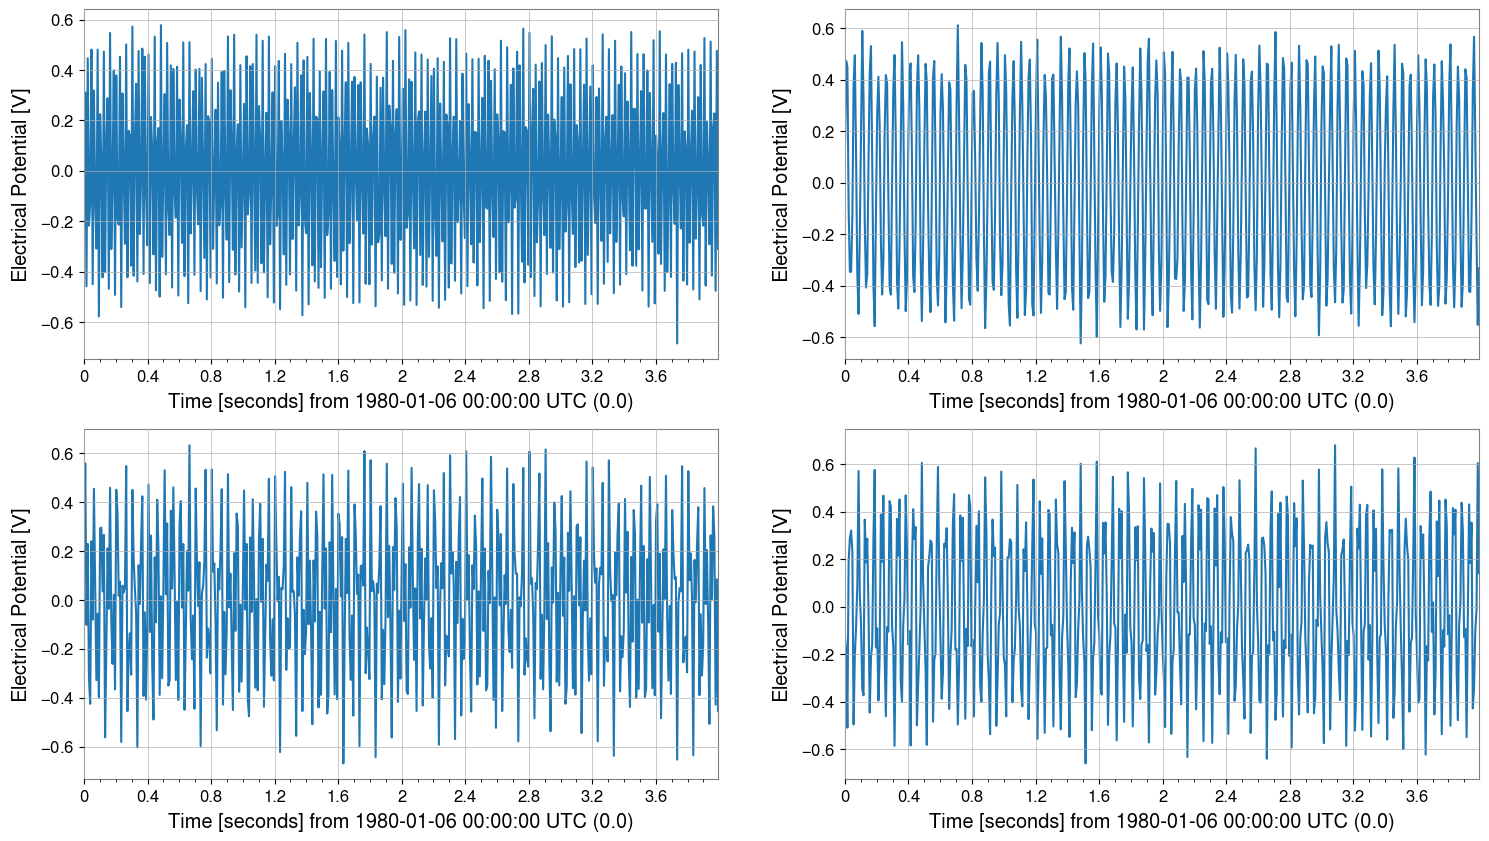

In [2]:
rng = np.random.default_rng(0)

# SampleSet
n = 512
dt = (1 / 128) * u.s
t0 = 0 * u.s

t = (np.arange(n) * dt).to_value(u.s)

tone50 = np.sin(2 * np.pi * 50 * t)
tone20 = np.sin(2 * np.pi * 20 * t + 0.3)

data = np.empty((2, 2, n), dtype=float)
data[0, 0] = 0.5 * tone50 + 0.05 * rng.normal(size=n)
data[0, 1] = 0.5 * tone20 + 0.05 * rng.normal(size=n)
data[1, 0] = 0.3 * tone50 + 0.3 * tone20 + 0.05 * rng.normal(size=n)
data[1, 1] = 0.2 * tone50 - 0.4 * tone20 + 0.05 * rng.normal(size=n)

units = np.full((2, 2), u.V)
names = [["ch00", "ch01"], ["ch10", "ch11"]]
channels = [["X:A", "X:B"], ["Y:A", "Y:B"]]

tsm = TimeSeriesMatrix(
    data,
    dt=dt,
    t0=t0,
    units=units,
    names=names,
    channels=channels,
    rows={"r0": {"name": "row0"}, "r1": {"name": "row1"}},
    cols={"c0": {"name": "col0"}, "c1": {"name": "col1"}},
    name="demo",
)

display(tsm)
tsm.plot()
plt.show()

## 2. SpectrogramMatrix の作成

`SpectrogramList` の `to_matrix()` メソッドを使用すると、全てのスペクトログラムが一つの `SpectrogramMatrix` にスタックされます。
これにより、形状が `(N, Time, Frequency)` の3次元配列が得られます。

Type: <class 'gwexpy.spectrogram.matrix.SpectrogramMatrix'>
Shape: (2, 2, 2, 33)


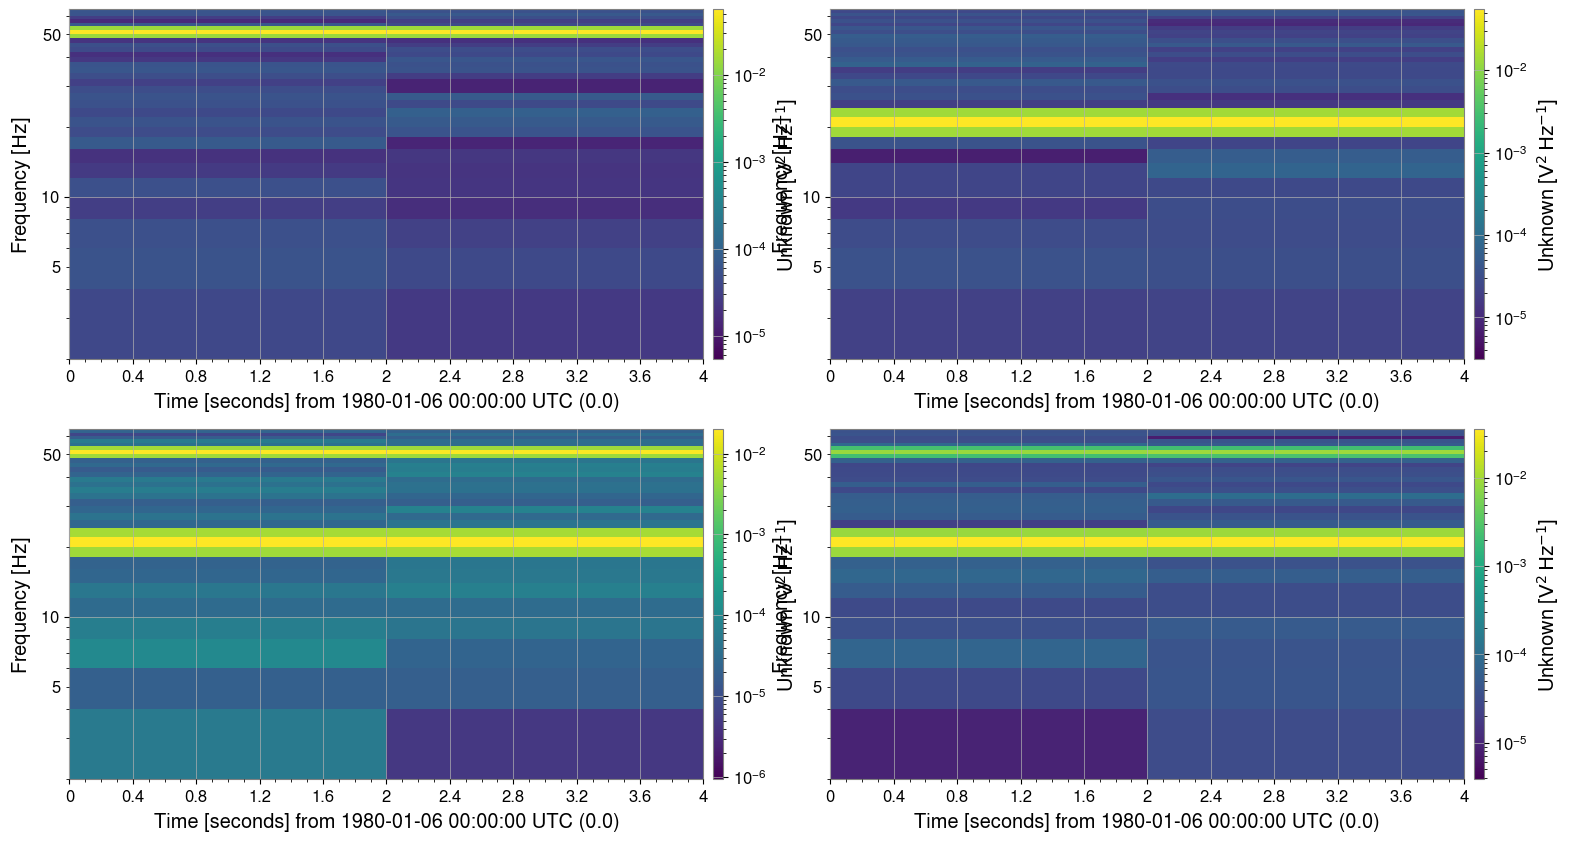

In [3]:
spec_matrix = tsm.spectrogram(2, fftlength=0.5, overlap=0.25)

print("Type:", type(spec_matrix))
print("Shape:", spec_matrix.shape) # (Batch, Time, Freq)
spec_matrix.plot();

### 属性へのアクセス
`SpectrogramMatrix` は元のスペクトログラムの時間軸や周波数軸の情報を保持しています。

In [4]:
print("Time axis (first 5):", spec_matrix.times[:5])
print("Freq axis (first 5):", spec_matrix.frequencies[:5])
print("Unit:", spec_matrix.unit)

Time axis (first 5): [0. 2.] s
Freq axis (first 5): [0. 2. 4. 6. 8.] Hz
Unit: V2 / Hz


## 3. 数値計算と統計

`SpectrogramMatrix` は `numpy.ndarray` のサブクラスであるため、Numpy の関数をそのまま適用できます。
また、`mean()` などのメソッドも利用可能です。

例えば、全チャネル（バッチ方向）の平均スペクトログラムを計算してみましょう。

In [5]:
# axis=0 (BatchAxis) Mean
mean_spectrogram_data = spec_matrix.mean(axis=0)

print("Mean Data Shape:", mean_spectrogram_data.shape)
# Result (Time, Freq) 2DimensionArray

Mean Data Shape: (2, 2, 33)


## 4. プロット

`plot()` メソッドを使用すると、データを可視化できます。
3次元データ（Batch, Time, Freq）に対して `plot()` を呼び出すと、デフォルトでは**バッチ方向の平均**がプロットされます。
これは複数のイベントの平均的な特徴を確認するのに便利です。

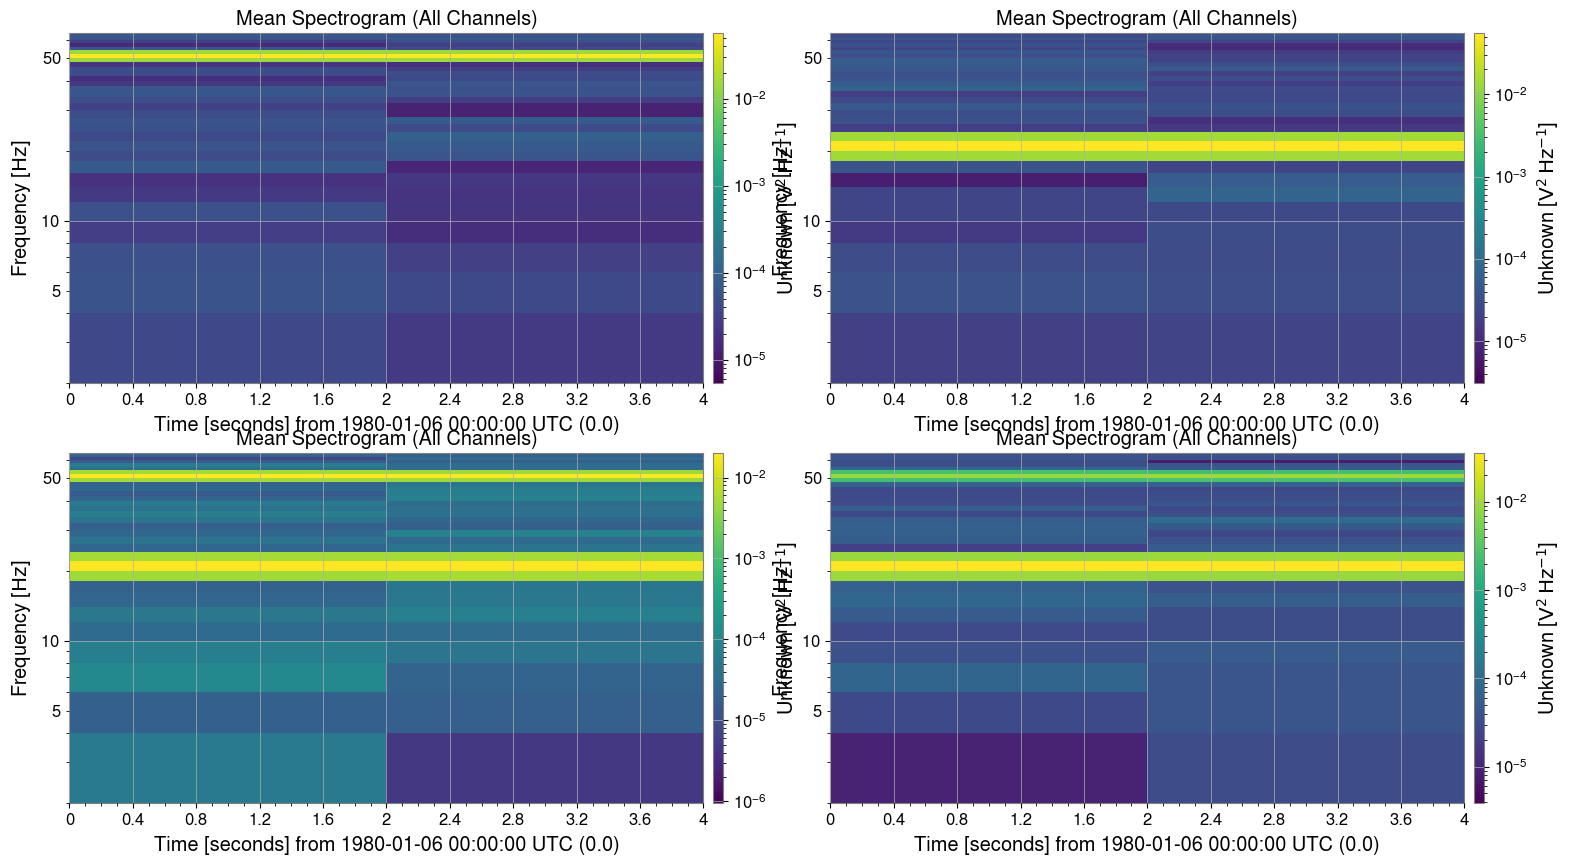

In [6]:
plot = spec_matrix.plot(title="Mean Spectrogram (All Channels)")
plt.show()

特定のチャネルだけをプロットしたい場合は、`monitor` 引数にインデックスを指定します。

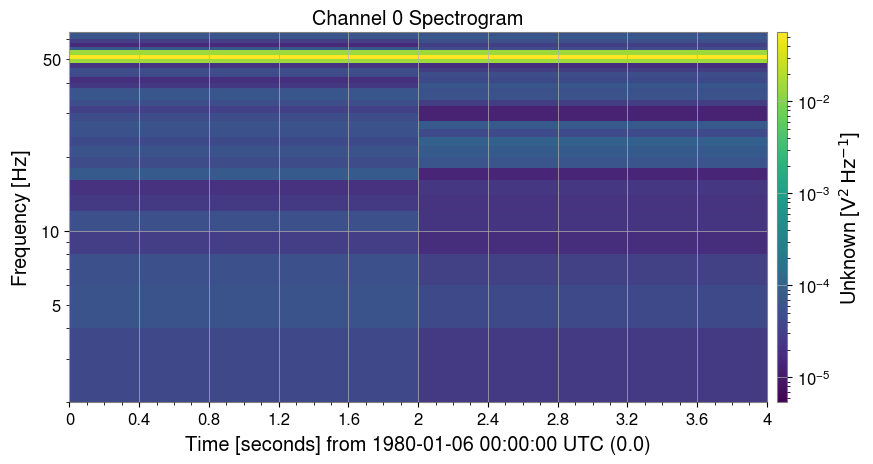

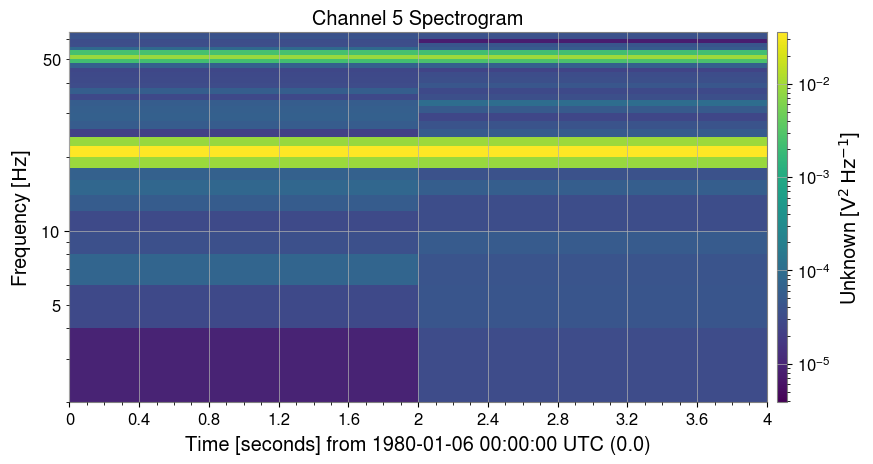

In [7]:
# (Channel_0) Plot
plot0 = spec_matrix.plot(monitor=0, title="Channel 0 Spectrogram")
plot0.show()

# 5 (Channel_5) Plot
plot5 = spec_matrix.plot(monitor=3, title="Channel 5 Spectrogram")
plot5.show()

## 5. 外部ライブラリとの連携

機械学習やGPU計算のために、PyTorch や CuPy のテンソルへ簡単に変換できます。

In [8]:
# PyTorch Tensor Transform
try:
    import torch

    _ = torch
    torch_tensor = spec_matrix.to_torch()
    print("PyTorch Tensor:", type(torch_tensor))
    print("Shape:", torch_tensor.shape)
except ImportError:
    print("PyTorch is not installed.")

# CuPy Array Transform（CUDA ）
from gwexpy.interop import is_cupy_available

if is_cupy_available():
    cupy_array = spec_matrix.to_cupy()
    print("CuPy Array:", type(cupy_array))
    print("Shape:", cupy_array.shape)
else:
    pass

PyTorch Tensor: <class 'torch.Tensor'>
Shape: torch.Size([2, 2, 2, 33])


## まとめ

- **`SpectrogramMatrix`** は `SpectrogramList.to_matrix()` で作成できます。
- 3次元配列 `(Batch, Time, Freq)` としてデータを保持します。
- `mean()` や `plot()` メソッドで、データの集約や可視化が簡単に行えます。
- `to_torch()` などでディープラーニングフレームワークへデータを渡す際の中間形式としても有用です。